# Classification with the perceptron and logistic regression

__Individual assignment__

Author of the assignment: Pierre Nugues

__Student name__: Bao Trung Hoang & Eric Portela 

## Objectives

The objectives of this second assignment are to:

1.  Write a linear regression program using gradient descent;
2.  Write linear classifiers using the perceptron algorithm and logistic regression;
3.  Experiment variations of the algorithms;
4.  Evaluate your classifiers;
5.  Experiment with popular tools;
6.  Read a scientific article on optimization techniques and comment it;
7.  Present your code, results, and comments in a short dissertation.

## Overview

The gradient descent is a basic technique to estimate the parameters of cost functions. 
1. You will first use the gradient descent method to implement linear regression. 
2. You will then program the perceptron algorithm. 
3. Finally, you will improve the threshold function with the logistic curve (logistic regression). 

You will try various configurations and study their influence on the learning speed and accuracy.

##  Programming language
As programming language, you will use Python and write your code in this notebook.

You need to have a comprehensive Python distribution such as Anaconda (https://www.anaconda.com/products/individual). This distribution is available on the student computers at the computer science department.
Finally, you start a notebook by typing:

`jupyter lab`

in a terminal window and you select the notebook by clicking on it in the left pane.
You run the pieces of code by typing shift+enter. You can also use a programming tool like VS Code or PyCharm.

## Imports
Imports you may use

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import random
import vector

## Linear Regression

You will implement the gradient descent method as explained in pages 694-697 in Russell-Norvig (pp. 719--720 in the 3rd ed.) and in the slides to compute regression lines. You will implement the stochastic and batch versions of the algorithm.

You must try to do it yourself first. If you encounter difficulties, you also have the solution to this exercise in the section _Solution to linear regression_ below. See: https://github.com/pnugues/edap01/tree/master/gradient_descent_practice

### Your implementation of linear regression
You will implement a regression program to predict the counts of _A_'s in a text from the total count of letters. You will apply it on two data sets corresponding to letter counts in the 15 chapters of the French and English versions of _Salammbô_, where the first column is the total count of characters and the second one, the count of A's. 

Start with either French or English and when your program ready, test it on the other language.

In [2]:
stat_fr = np.array([[36961, 2503],
                    [43621, 2992],
                    [15694, 1042],
                    [36231, 2487],
                    [29945, 2014],
                    [40588, 2805],
                    [75255, 5062],
                    [37709, 2643],
                    [30899, 2126],
                    [25486, 1784],
                    [37497, 2641],
                    [40398, 2766],
                    [74105, 5047],
                    [76725, 5312],
                    [18317, 1215]])

stat_en = np.array([[35680, 2217],
                    [42514, 2761],
                    [15162, 990],
                    [35298, 2274],
                    [29800, 1865],
                    [40255, 2606],
                    [74532, 4805],
                    [37464, 2396],
                    [31030, 1993],
                    [24843, 1627],
                    [36172, 2375],
                    [39552, 2560],
                    [72545, 4597],
                    [75352, 4871],
                    [18031, 1119]])

From the datasets above, tell what is ${X}$ and $\mathbf{y}$. Extract:
1. The ${X}$ matrix, where you will have a column to model the intercept;
2. The $\mathbf{y}$ vector

from these arrays.

X (the predictor variable) and y (the response variable)

In [3]:
# Write your code here
# Extract the X and y for the English dataset.

# predictor variable
X = stat_en[:,0]
X = np.column_stack((np.ones(len(stat_en),dtype = np.int8), stat_en[:,0]))

# the response variable 
y = stat_en[:,1]

print(X)
print(y)


[[    1 35680]
 [    1 42514]
 [    1 15162]
 [    1 35298]
 [    1 29800]
 [    1 40255]
 [    1 74532]
 [    1 37464]
 [    1 31030]
 [    1 24843]
 [    1 36172]
 [    1 39552]
 [    1 72545]
 [    1 75352]
 [    1 18031]]
[2217 2761  990 2274 1865 2606 4805 2396 1993 1627 2375 2560 4597 4871
 1119]


Scale the arrays so that they fit in the range [0, 1] on the $x$ and $y$ axes. 

In [4]:
# for the purpose of scaling the arrays so they fit in the range of [0,1], we use Min-max scaling or standardization
# Write your code here
def cus_min_max_scaling(data):
    min_value = np.min(data)
    max_value = np.max(data)
    return (data - min_value) / (max_value - min_value)   

In [5]:
# scale data
# for predictor variable
X_temp = cus_min_max_scaling(X[:,1])
X_scaled = np.column_stack((np.ones(len(stat_en),dtype = np.int8), X_temp))

# for response variable 
y_scaled = cus_min_max_scaling(y)

print(X_scaled)
print(y_scaled)

[[1.         0.34088719]
 [1.         0.45442765]
 [1.         0.        ]
 [1.         0.33454062]
 [1.         0.24319654]
 [1.         0.41689649]
 [1.         0.98637647]
 [1.         0.37052667]
 [1.         0.26363183]
 [1.         0.16084067]
 [1.         0.34906131]
 [1.         0.40521681]
 [1.         0.95336435]
 [1.         1.        ]
 [1.         0.04766573]]
[0.31615563 0.45632569 0.         0.33084257 0.22545736 0.41638753
 0.98299407 0.36227776 0.25843855 0.16413296 0.35686679 0.40453491
 0.92939964 1.         0.03323886]


#### Gradient descent

Loss function

In [6]:
def sse(X, y ,w):
    error = y - X @ y
    return error.T @ error

error.T @ error performs a dot product between the transposed error vector and the orginal error vector.
This operations equates to summing the sequences of all individual errors 

Function to predict value

In [7]:
def predict(X,w):
    return X @ w

Implement the descent functions. You will pass `X`, `y`, the learning rate in the $\alpha$ variable, the initial weight vector in `w`, the tolerance in the $\epsilon$ variable, the maximal number of epochs in `epochs`. You will return `w`.

Batch descent

In [8]:
# Write your code here
def fit_batch(X, y, alpha, w,
                  epochs=500,
                  epsilon=1.0e-5):
    #pred = predict(X, w)
    # Track loss over time 
    losses = []
    
    n_samples, n_features = X.shape 
    for e in range (epochs):
        y_pred = predict (X, w)
        error = y - y_pred
        loss = np.mean(error**2)  # Mean squared error
        losses.append(loss)
        #calculate gradient
        gradient = (1 / n_samples) * np.dot(X.T, error)
        # update weights:
        w = w + alpha * gradient
        
        # Check convergence
        if e > 0 and abs(losses[e] - losses[e-1]) < epsilon:
            print(f"Converged after {e+1} epochs")
            break
            
    print("Epoch", e)
    return w, losses                 

Stochastic descent

In [45]:
def fit_stoch(X, y, alpha, w,
                  epochs=500,
                  epsilon=1.0e-5):
    # Track loss over time
    losses = []
    # make sure the same results are produced every time. 
    random.seed(0)
    # the indicies will be suffled.
    indicies = list(range(len(X)))
    for epoch in range(epochs):
        random.shuffle(indicies)
        for i in indicies:
            # make the prediction 
            y_pred = predict([X[i]], w)[0]
            error = y[i] - y_pred
            #update the weight.
            gradient = X[i:i + 1].T * error
            w = w + alpha * gradient
        if np.linalg.norm(gradient) < epsilon:
            print('Gradient', np.linalg.norm(gradient))
            break
    print("Final Epoch:", epoch)
    return w 

#### Applying batch descent

Apply the batch descent and print the final weight values 

In [148]:
X_scaled.shape[1]

2

In [149]:
# Write your code here

# the weights are initialized with zeros i.e w0 = 0 and w1 = 0, contained inside of an array.
w = np.zeros((X_scaled.shape[1],1))
new_w, losses = fit_batch(X_scaled, y_scaled, 0.1, w)
print(new_w)

Converged after 296 epochs
Epoch 295
[[0.03205636]
 [0.91668494]]


Visualize the points of your dataset as well as the regression lines you obtain using matplotlib or another similar program.

the weights is  [[0.03205636]
 [0.91668494]]
0.0
1.0
[1114.41074657]
[4672.06498246]


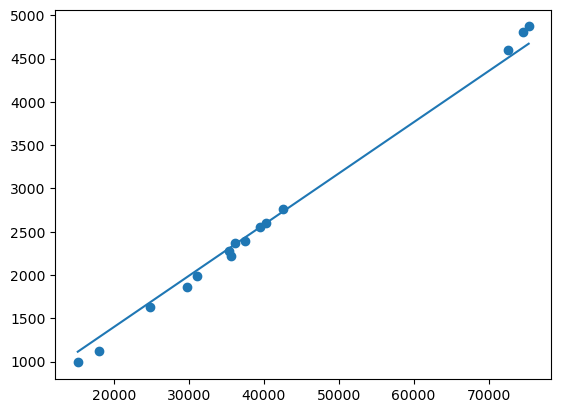

In [150]:
min_X = np.min(stat_en[:, 0])  # Minimum of total character
max_X = np.max(stat_en[:, 0])  # Maximum of total character counts
min_y = np.min(stat_en[:, 1])  # Minimum of 'A' counts
max_y = np.max(stat_en[:, 1])  # Maximum of 'A' counts
# res-scale to the original value.
x_fig = X_scaled[:, 1] * (max_X - min_X) + min_X  # Scale back the X values
y_fig = y_scaled * (max_y - min_y) + min_y        # Scale back the y values
#use the predict function to y values from min_x and max_y for the regression line
print("the weights is ", new_w)
min_scaled_x = np.min(X_scaled[:,1])
max_scaled_x = np.max(X_scaled[:,1])
print (min_scaled_x)
print (max_scaled_x)
y_min_pred = np.array([1, min_scaled_x]) @ new_w
y_max_pred = np.array([1, max_scaled_x]) @ new_w
#convert to original scale
min_scaled_x = min_scaled_x * (max_X - min_X) + min_X 
y_min_pred = y_min_pred * (max_y - min_y) + min_y
max_scaled_x = max_scaled_x * (max_X - min_X) + min_X
y_max_pred = y_max_pred * (max_y - min_y) + min_y
print(y_min_pred)
print(y_max_pred)

#plot data-points and the regression lines
plt.scatter(x_fig, y_fig)
plt.plot([min_scaled_x, max_scaled_x], 
         [y_min_pred, y_max_pred])
plt.show()

#### Stochastic descent

In [13]:
def normalize(Xy):
    maxima = np.amax(Xy, axis=0)
    Xy = 1/maxima * Xy
    return Xy

In [46]:
# scale data
# for predictor variable
X_temp = normalize(X[:,1])
X_scaled = np.column_stack((np.ones(len(stat_en),dtype = np.int8), X_temp))

# for response variable 
y_scaled = normalize(y)
y_scaled = y_scaled.reshape(-1, 1)

print(X_scaled)
print(X_scaled.shape)
print(y_scaled)
print(y_scaled.shape)

[[1.         0.47351099]
 [1.         0.56420533]
 [1.         0.20121563]
 [1.         0.46844145]
 [1.         0.39547723]
 [1.         0.53422603]
 [1.         0.98911774]
 [1.         0.49718654]
 [1.         0.41180062]
 [1.         0.32969264]
 [1.         0.48004034]
 [1.         0.52489649]
 [1.         0.96274817]
 [1.         1.        ]
 [1.         0.23929026]]
(15, 2)
[[0.45514268]
 [0.56682406]
 [0.20324369]
 [0.46684459]
 [0.38287826]
 [0.53500308]
 [0.98645042]
 [0.49189078]
 [0.40915623]
 [0.33401766]
 [0.48757955]
 [0.52555943]
 [0.94374872]
 [1.        ]
 [0.22972696]]
(15, 1)


In [47]:
w = np.zeros((X_scaled.shape[1], 1))
print("Initial w shape:", w.shape)

# Fit the model
new_w = fit_stoch(X_scaled, y_scaled, 0.1, w)
print("Final weights:", new_w)
print("Weight shape:", new_w.shape)

Initial w shape: (2, 1)
Final Epoch: 499
Final weights: [[3.49614446e-05]
 [9.94708728e-01]]
Weight shape: (2, 1)


Visualize the points of your dataset as well as the regression lines you obtain using matplotlib or another similar program.

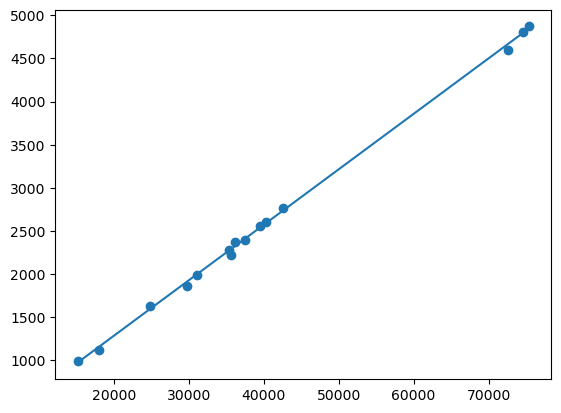

In [48]:
# Write your code here.
maxima_X = np.max(stat_en[:,0])
maxima_y = np.max(stat_en[:,1])

x_fig = X_scaled[:,1] * maxima_X
y_fig = y_scaled * maxima_y
#use the generated weights to draw a line.

min_scaled_x = np.min(X_scaled[:,1])
max_scaled_x = np.max(X_scaled[:,1])

# make the prediction
y_min_pred = np.array([1, min_scaled_x]) @ new_w
y_max_pred = np.array([1, max_scaled_x]) @ new_w

# convert to original scale: 
min_x = min_scaled_x * maxima_X
max_x = max_scaled_x * maxima_X
min_y = y_min_pred * maxima_y 
max_y = y_max_pred * maxima_y

# show the plot. 
plt.scatter(x_fig, y_fig)
plt.plot([min_x, max_x],
        [min_y, max_y])
plt.show()

### A solution to linear regression

To help you start this assignment, your instructor wrote two Python notebooks that solve this exercise on linear regression. You can find them here: https://github.com/pnugues/edap01/tree/master/gradient_descent_practice

2. The first notebook, `gradient_descent_numpy.ipynb`, uses Numpy. It is more compact, but you need to know a bit of numpy, for instance you multiply matrix `M` by matrix `N` with the operation `M @ N`
1. The second notebook, `gradient_descent.ipynb`, only uses Python. The vector and matrix operations such as the dot product that are in the `vector.py` file. You can see how your instructor write the dot product or matrix multiplication operations so that there is no magic as with NumPy


To run these programs, download them on your computer as well as the other program in the import list: vector.py

The programs are also available as Python programs from
https://github.com/pnugues/ilppp/tree/master/programs/ch04/python

## Classification
You will use the same data set as for linear regression, but this time to classify a chapter as French or English. Given a pair of numbers corresponding the letter count and count of _A_, you will predict the language:
1. $\mathbf{x} = (35680, 2217)$ $\to$ $y$ = English
2. $\mathbf{x} = (37497, 2641)$ $\to$ $y$ = French

### The dataset
You will use the arrays below:
1. `X` contains the counts of letters and of _A_ s as well as a column of ones for the intercept;
2. `y` contains the classes, where 0 is for English and 1 for French.

In [2]:
X = np.array([[1.0, 35680.0, 2217.0],
              [1.0, 42514.0, 2761.0],
              [1.0, 15162.0, 990.0],
              [1.0, 35298.0, 2274.0],
              [1.0, 29800.0, 1865.0],
              [1.0, 40255.0, 2606.0],
              [1.0, 74532.0, 4805.0],
              [1.0, 37464.0, 2396.0],
              [1.0, 31030.0, 1993.0],
              [1.0, 24843.0, 1627.0],
              [1.0, 36172.0, 2375.0],
              [1.0, 39552.0, 2560.0],
              [1.0, 72545.0, 4597.0],
              [1.0, 75352.0, 4871.0],
              [1.0, 18031.0, 1119.0],
              [1.0, 36961.0, 2503.0],
              [1.0, 43621.0, 2992.0],
              [1.0, 15694.0, 1042.0],
              [1.0, 36231.0, 2487.0],
              [1.0, 29945.0, 2014.0],
              [1.0, 40588.0, 2805.0],
              [1.0, 75255.0, 5062.0],
              [1.0, 37709.0, 2643.0],
              [1.0, 30899.0, 2126.0],
              [1.0, 25486.0, 1784.0],
              [1.0, 37497.0, 2641.0],
              [1.0, 40398.0, 2766.0],
              [1.0, 74105.0, 5047.0],
              [1.0, 76725.0, 5312.0],
              [1.0, 18317.0, 1215.0]])
y = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
              1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

We visualize it

In [12]:
x_fr = [x[1] for i, x in enumerate(X) if y[i] == 1]
y_fr = [x[2] for i, x in enumerate(X) if y[i] == 1]
x_en = [x[1] for i, x in enumerate(X) if y[i] == 0]
y_en = [x[2] for i, x in enumerate(X) if y[i] == 0]

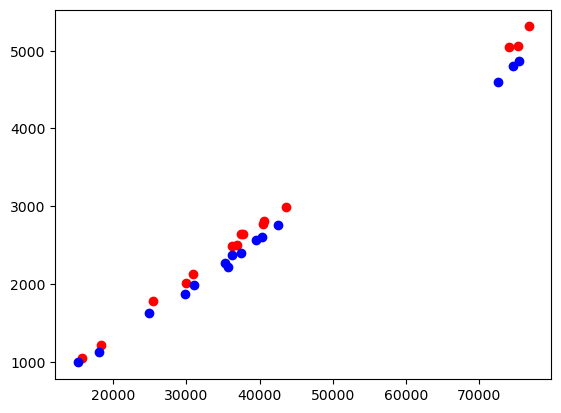

In [13]:
plt.scatter(x_fr, y_fr, color='red')
plt.scatter(x_en, y_en, color='blue')

### Normalize the dataset

Gradient descent algorithms can be very sensitive to the range. Therefore, we normalize the dataset.

In [3]:
def normalize(Xy):
    maxima = np.amax(Xy, axis=0)
    Xy = 1/maxima * Xy
    return (Xy, maxima)

In [4]:
X_norm, maxima = normalize(X)
X_norm

array([[1.        , 0.46503747, 0.41735693],
       [1.        , 0.55410883, 0.51976657],
       [1.        , 0.19761486, 0.18637048],
       [1.        , 0.46005865, 0.42808735],
       [1.        , 0.38840013, 0.35109187],
       [1.        , 0.52466601, 0.49058735],
       [1.        , 0.9714174 , 0.90455572],
       [1.        , 0.48828935, 0.45105422],
       [1.        , 0.40443141, 0.37518825],
       [1.        , 0.32379277, 0.30628765],
       [1.        , 0.47144998, 0.4471009 ],
       [1.        , 0.51550342, 0.48192771],
       [1.        , 0.94551971, 0.8653991 ],
       [1.        , 0.98210492, 0.91698042],
       [1.        , 0.23500815, 0.21065512],
       [1.        , 0.48173346, 0.47119729],
       [1.        , 0.56853698, 0.56325301],
       [1.        , 0.20454871, 0.19615964],
       [1.        , 0.47221896, 0.46818524],
       [1.        , 0.39029   , 0.37914157],
       [1.        , 0.52900619, 0.5280497 ],
       [1.        , 0.98084066, 0.95293675],
       [1.

## The Perceptron

1. Write the perceptron program as explained in pages 700--702 in Russell-Norvig (pp. 723--725 in the 3rd ed.) and in the slides and run it on your data set. As suggested program structure, use two functions: 
 * `fit(X, y)` that will return `w` (the model). You can choose a stochastic or batch variant;
 * `predict(X, w)` that will return `y_hat`. You can encapsulate these functions in a class and, of course, add more parameters.
2. As a stop criterion, you will use the number of misclassified examples.
3. You will report the parameters you have used and the weight vector

You can use numpy or not. The next cells are just suggested steps. You can implement it your way.

### The `predict(X, w)` function
Write a `predict(X, w)` function that given a matrix of observations ${X}$ and a weight vector $\mathbf{w}$ will return a $\mathbf{\hat{y}}$ vector classes (0 or 1)

In [17]:
# Write your code here
def predict(X, w):
    activation = np.dot(X,w)
    if activation >= 0:
        return 1
    else:
        return 0

### The `fit(X, y)` function

Write a `fit(X, y)` function that given a matrix of observations ${X}$ and a vector of responses $\mathbf{y}$ will return a weight $\mathbf{w}$ vector. You may use the other arguments of the function, notably the number of misclassified examples to define the stop condition.

In [18]:
# Write your code here
def fit_stoch(X, y,
              epochs=1000,
              max_misclassified=0,
              learning_rate = 0.1,
              random_seed=42,
              verbose=True):
    w = np.zeros(X.shape[1])

    #Start the training for a specified number of epochs
    for epoch in range(epochs):
        #set up the random seed for reproducibility
        np.random.seed(random_seed + epoch)
        # The number of misclassified 
        misclassified = 0
        # indices for each element in the observation. 
        indices = np.arange(len(X))
        #shuffle indices for sample. 
        indices = np.random.permutation(indices)
        for i in indices:
            activation = np.dot(X[i],w)
            prediction = 1 if activation >= 0 else 0
            if prediction != y[i]:
                misclassified += 1
                w = w + learning_rate * (y[i] - prediction) * X[i]
        # return weights when the number of misclassified is smaller than max_misclassified. 
        if misclassified <= max_misclassified:
            print (f" The training ends after {epoch} epochs")
            return w
    # The weights will be returned after all epochs.         
    return w

### Fitting the dataset

In [19]:
w = fit_stoch(X_norm, y)
print(w)

 The training ends after 40 epochs
[ 0.         -0.44246856  0.46423193]


In [20]:
w = [w[i] * maxima[-1] / maxima[i] for i in range(len(w))]
print("Restored weights", w)
w = [w[j] / w[-1] for j in range(len(w))]
print("Weights with y set to 1", w)

Restored weights [np.float64(0.0), np.float64(-0.03063399116720349), np.float64(0.46423192771084304)]
Weights with y set to 1 [np.float64(0.0), np.float64(-0.06598854869431672), np.float64(1.0)]


### Visualizing the results

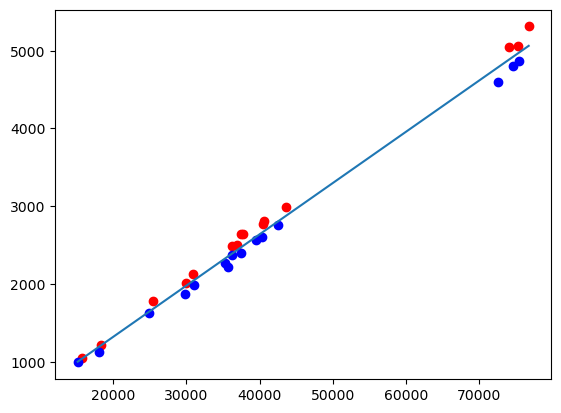

In [21]:
plt.scatter(x_fr, y_fr, color='red')
plt.scatter(x_en, y_en, color='blue')
plt.plot([min(x_fr + x_en), max(x_fr + x_en)],
         [-w[1] * min(x_fr + x_en) - w[0], -w[1] * max(x_fr + x_en) - w[0]])

### Evaluation
Evaluate your perceptron using the leave-one-out cross validation method. You will have to train and run 30 models. In each train/run session, you will train on 29 samples and evaluate on the remaining sample. You have then either a correct or a wrong classification. You will sum these classifications, i.e. the number of correct classifications, to get your final evaluation, for instance 29/30.

In [29]:
# Write your code here
def leave_one_out_cross_val(X, y, fitting_function):
    score = 0
    for i in range(len(y)):
        # create the training set and test set. 
        # the train data.
        x_train = np.delete(X, i, axis = 0)
        y_train = np.delete(y, i, axis = 0)
        # The test data, using the Python's slicing notation  
        x_test = X[i:i+1]
        y_test = y[i]
        # Train on the training set 
        w = fit_stoch(x_train, y_train)
        # make the prediction 
        prediction = predict(x_test,w)
        if prediction == y_test:
            score += 1
            print(f"Fold {i} on {len(y)}, weights: {w}: Correct. ")
        else:
            print(f"Fold {i} on {len(y)}, weights: {w}: Wrong. ")
    return score / len(y)

In [30]:
stoch_accuracy = leave_one_out_cross_val(X_norm, y, fit_stoch)
print('Cross-validation accuracy (stochastic):', stoch_accuracy)

 The training ends after 22 epochs
Fold 0 on 30, weights: [ 0.         -0.25855327  0.27044428]: Correct. 
 The training ends after 60 epochs
Fold 1 on 30, weights: [ 0.         -0.68786184  0.72387048]: Correct. 
 The training ends after 69 epochs
Fold 2 on 30, weights: [ 0.         -0.81320691  0.85363328]: Correct. 
 The training ends after 42 epochs
Fold 3 on 30, weights: [ 0.         -0.49088824  0.51656627]: Correct. 
 The training ends after 24 epochs
Fold 4 on 30, weights: [ 0.         -0.28421636  0.29952937]: Correct. 
 The training ends after 14 epochs
Fold 5 on 30, weights: [ 0.         -0.18223004  0.19167922]: Correct. 
 The training ends after 20 epochs
Fold 6 on 30, weights: [ 0.         -0.21143304  0.22176205]: Correct. 
 The training ends after 25 epochs
Fold 7 on 30, weights: [ 0.         -0.30185989  0.31639684]: Correct. 
 The training ends after 42 epochs
Fold 8 on 30, weights: [ 0.         -0.47195178  0.49471009]: Correct. 
 The training ends after 49 epochs
Fo

## Logistic Regression
From your perceptron program, implement logistic regression. You can either follow the description from the slides or from the textbook, S. Russell and R. Norvig, _Artificial Intelligence_, 2022, pages 702--704 (pp. 725--727 in the 3rd ed.). Note that the textbook uses a criterion that is rejected by most practioners. You can either implement the stochastic or the batch version of the algorithm, or both versions. As stop criterion, you will use either the norm of the gradient or the norm of the difference between two consecutive weight vectors. You will also set a maximal number of epochs. Run the resulting program on your dataset.

Write the logistic function, where the $\mathbf{x}$ input is a vector of real numbers.

In [5]:
# Write your code here
def logistic(x):
    return 1 / (1 + np.exp(-x))

### The `predict(X, w)` function

Write a `predict_proba()` function that given a matrix of observations ${X}$ and a weight vector $\mathbf{w}$ will return a vector of probabilities to belong to class 1: The vector will consist of $P(1|\mathbf{x}_i)$ for all the $i$ rows of ${X}$.

In [6]:
# Write your code here
def predict_proba(X, w):
    return logistic(np.dot(X, w))

Write a `predict(X, w)` function that given a matrix of observations ${X}$ and a weight vector $\mathbf{w}$ will return the class. You will use `predict_proba()` and set the threshold to belong to class 1 to 0.5.

In [7]:
# Write your code here
def predict(X, w):
    probas = predict_proba(X, w)
    return (probas >= 0.5).astype(int)

### The `fit(X, y)` function

You will now write the `fit(X, y)` function as with the perceptron. You may call it `fit_stoch(X, y)` or `fit_batch(X, y)`. Use the parameters given in the cell below.

In [31]:

def fit_stoch(X, y, alpha=1, epochs=1000, epsilon=1.0e-4, random_seed=1, verbose=False):
    w = np.zeros(X.shape[1])
    
    prev_likelihood = float('-inf')
    
    for epoch in range(epochs):
        #set up the random seed for reproducibility
        np.random.seed(random_seed + epoch)
        #indicies for each sample in the observation
        indices = np.arange(len(X))
        #shuffle indices for samples. 
        indices = np.random.permutation(indices)
        
        current_likelihood = 0
        
        for i in indices:
            # Get prediction probability
            p = predict_proba(X[i:i+1], w)
            
            # Update weights
            error = y[i] - p
            w = w + alpha * X[i] * error
            
            # Accumulate log-likelihood
            current_likelihood += y[i] * np.log(p) + (1 - y[i]) * np.log(1 - p)
        
        # Check for convergence based on likelihood improvement
        if abs(current_likelihood - prev_likelihood) < epsilon:
            break
            
        prev_likelihood = current_likelihood
     # return the weights    
    return w

In [32]:
w = fit_stoch(X_norm, y)
w

array([ -0.47696873, -54.63279598,  57.21731869])

In [33]:
w = [w[i] / maxima[i] for i in range(len(w))]
print("Restored weights", w)
w = [w[j] / w[-1] for j in range(len(w))]
print("Weights with y set to 1", w)

Restored weights [np.float64(-0.47696872847839006), np.float64(-0.0007120599019614156), np.float64(0.010771332584556632)]
Weights with y set to 1 [np.float64(-44.28131103873282), np.float64(-0.06610694604141455), np.float64(1.0)]


### Visualizing the results

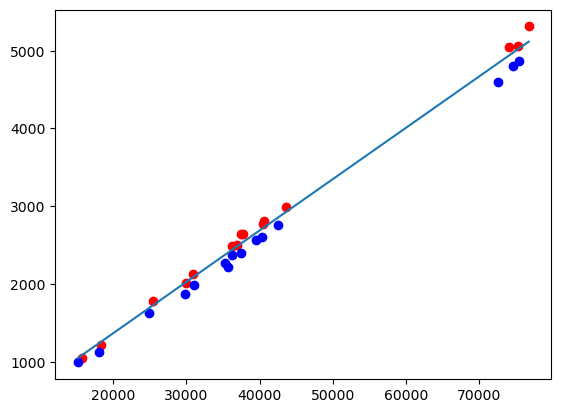

In [34]:
plt.scatter(x_fr, y_fr, color='red')
plt.scatter(x_en, y_en, color='blue')
plt.plot([min(x_fr + x_en), max(x_fr + x_en)],
         [-w[1] * min(x_fr + x_en) - w[0], -w[1] * max(x_fr + x_en) - w[0]])
plt.show()

### Evaluation
Evaluate your logistic regression using the leave-one-out cross validation method as with the perceptron

In [35]:
# Write your code here
def leave_one_out_cross_val(X, y, fitting_function):
    score = 0
    for i in range(len(y)):
        # Split data
        x_train = np.delete(X, i, axis=0)
        y_train = np.delete(y, i, axis=0)
        x_test = X[i:i+1]
        y_test = y[i]
        
        # Train and predict
        w = fit_stoch(x_train, y_train)
        prediction = predict(x_test, w)
        
        # Score
        if prediction == y_test:
            score += 1
    return score / len(y)

In [36]:
stoch_accuracy = leave_one_out_cross_val(X_norm, y, fit_stoch)
print('Cross-validation accuracy (batch):', stoch_accuracy)

Cross-validation accuracy (batch): 0.9333333333333333


## Visualizing the logistic surface

In [16]:
def plot_logistic_surf(x_range, y_range, w_opt):
    x_axis, y_axis = np.meshgrid(x_range, y_range)

    # We compute the probability surface as a function of x and y
    # First generate the (1, x, y) tuples
    grid = np.array([[[1.0, i, j] for j in y_range] for i in x_range])
    # Then, compute logistic((1, x, y) . w_opt)
    z_axis = logistic((grid @ w_opt))
    return x_axis, y_axis, z_axis.T

C:\Users\Admin\AppData\Local\Temp\ipykernel_28944\3012075495.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


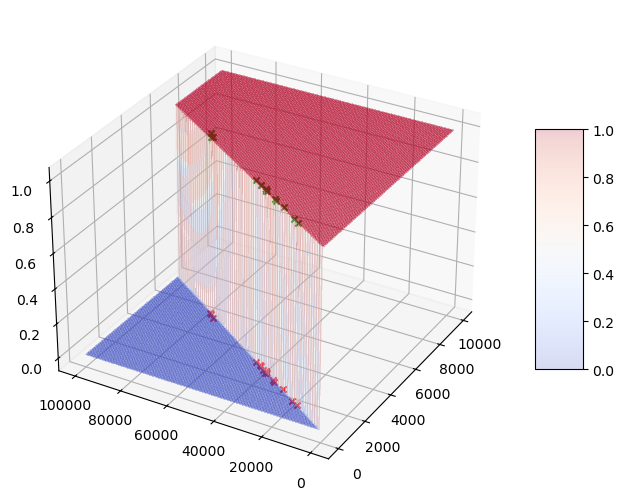

In [59]:
x_range = np.linspace(0, 100000, 200)
y_range = np.linspace(0, 10000, 200)
# w = [2.073225839414742, -0.049125455233437906, 0.7440143556104162]

x_axis, y_axis, z_axis = plot_logistic_surf(x_range, y_range, w)

fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

surf = ax.plot_surface(y_axis, x_axis, z_axis, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.2)
fig.colorbar(surf, shrink=0.5, aspect=5)
# We plot the observations
for x, y_class in zip(X, y):
    if y_class == 1:
        ax.scatter(x[2], x[1], y_class, color='green', marker='x')
    else:
        ax.scatter(x[2], x[1], y_class, color='red', marker='x')

ax.elev = 30
ax.azim = -150
plt.show()

## Programming logistic regression with popular APIs
Should you use logistic regression in a project, you will probably resort to existing libraries. In three separate notebooks, you will apply the logistic regression classification with three popular APIs:
1. sklearn
2. PyTorch
3. Keras

`sklearn` is included in anaconda.
You will install the rest, ans possibly more, with:
```
pip2 install --upgrade keras 
pip3 install --upgrade torch
```
You will read and run the code in these three separate notebooks.

## Reading
You will read the article *An overview of gradient descent optimization algorithms* by Ruder (2017) and you will outline the main characteristics of all the optimization algorithms the author describes. This part should be of about one to two pages. Link to the article: https://arxiv.org/abs/1609.04747.

You can also visualize the descents of the algorithm variants on Ruder's webpage: https://www.ruder.io/optimizing-gradient-descent/.

If you understand French, or using Google translate, you may also want to read the original article on gradient descent by Cauchy here:  https://gallica.bnf.fr/ark:/12148/bpt6k2982c/f540.item.


### Report

The assignment must be documented in the report, which should contain the following:

*   The name of the author, the title of the assignment, and any relevant information on the front page;
*   A presentation of the assignment and the possible improvements you would have brought;
*   A presentation of your implementation;
*   A print-out of the example set(s) and the resulting weight vectors;
*   Comments on the results you have obtained, including your cross validation;
*   A short dissertation on the optimization algorithms from Ruder's paper.

Please, typeset and format your report consistently. You must use Latex. Documents written using MS Word or any similar format will not be considered.

You may have a look at the code in the textbook code repository (or any other implementations), but the code you hand in must be your work.

## Submission
Submit the notebook and the report to Canvas (two files). Do not include the code printout in the report, but only comments on its interesting parts. You will submit the notebook as a separate file.